# 2025-09-29 QR Retrospective

## Last time

* Right vs left-looking algorithms
* Elementary reflectors
* Householder QR

## Today

* Householder fix
* Comparison of interfaces
* Profiling
* Cholesky QR

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

# Householder QR

Gram-Schmidt constructed a triangular matrix $R$ to orthogonalize $A$ into $Q$. Each step was a projector, which is a rank-deficient operation. Householder uses orthogonal transformations (reflectors) to triangularize.

$$ \underbrace{Q_{n} \dotsb Q_1}_{Q^T} A = R $$

The structure of the algorithm is

$$ \underbrace{\begin{bmatrix} * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ \end{bmatrix}}_{A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ \end{bmatrix}}_{Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & * \\ 0 & 0 & * \\ \end{bmatrix}}_{Q_2 Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ \end{bmatrix}}_{Q_3 Q_2 Q_1 A}
$$

# Constructing the $Q_j$

$$ \underbrace{Q_{n} \dotsb Q_1}_{Q^T} A = R $$

Each of our $Q_j$ will have the form
$$Q_j = \begin{bmatrix} I_i & 0 \\ 0 & F \end{bmatrix}$$
where $F$ is a "reflection" that achieves
$$ F x = \begin{bmatrix} \lVert x \rVert \\ 0 \\ 0 \\ \vdots \end{bmatrix} $$
where $x$ is the column of $R$ from the diagonal down.
This transformation is a reflection across a plane with normal $v = Fx - x = \lVert x \rVert e_1 - x$.

![Householder Reflector (Trefethen and Bau, 1999)](../img/TB-Householder.png)

The reflection, as depicted above by Trefethen and Bau (1999) can be written $F = I - 2 \frac{v v^T}{v^T v}$.

# Adventures in reflection

In [29]:
A = rand(4, 4); A += A'
v = copy(A[:,1])
v[1] -= norm(v)
v = normalize(v)
F = I - 2 * v * v'
B = F * A

4×4 Matrix{Float64}:
 2.00074       2.19872    1.91185    2.2909
 1.54919e-16   0.242686  -0.808393  -0.281889
 9.41728e-17   0.434702   0.71182    0.987804
 1.88833e-16  -0.647386  -0.62522   -0.158602

In [30]:
v = copy(B[2:end, 2])
v[1] -= norm(v); v = normalize(v)
F = I - 2 * v * v'
B[2:end, 2:end] = F * B[2:end, 2:end]
B

4×4 Matrix{Float64}:
 2.00074       2.19872       1.91185   2.2909
 1.54919e-16   0.816682      0.634276  0.567744
 9.41728e-17   1.11022e-16  -0.380749  0.344356
 1.88833e-16  -1.66533e-16   1.0019    0.799661

# An algorithm

In [32]:
function qr_householder_naive(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] -= norm(v)
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * (v' * R[j:end,j:end])
        push!(V, v)
    end
    V, R
end

qr_householder_naive (generic function with 1 method)

In [35]:
m = 4
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder_naive(A)
_, R_ = qr(A)
R_

4×4 Matrix{Float64}:
 -2.0  0.0      -1.11111      0.0
  0.0  1.49071   1.38778e-17  1.3582
  0.0  0.0       0.888889     9.71445e-17
  0.0  0.0       0.0          0.397523

# How to interpret $V$ as $Q$?

In [6]:
function reflectors_mult(V, x)
    y = copy(x)
    for v in reverse(V)
        n = length(v) - 1
        y[end-n:end] -= 2 * v * (v' * y[end-n:end])
    end
    y
end

function reflectors_to_dense(V)
    m = length(V[1])
    Q = diagm(ones(m))
    for j in 1:m
        Q[:,j] = reflectors_mult(V, Q[:,j])
    end
    Q
end

reflectors_to_dense (generic function with 1 method)

In [36]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder_naive(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 3.7994490775439526e-15
norm(Q * R - A) = 7.562760794606217e-15


# Great, but we can still break it

In [71]:
A = [0 2; 1e-2 1.]
V, R = qr_householder(A)
#Q, R = qr(A)
R

2×2 Matrix{Float64}:
  0.01          1.0
 -1.73472e-18  -2.0

We had the lines

```julia
    v = copy(R[j:end, j])
    v[1] -= norm(v)
    v = normalize(v)
```
What happens when `R` is already upper triangular?

![Choosing the better of two Householder reflectors (Trefethen and Bau, 1999).](../img/TB-Householder2.png)

# An improved algorithm



In [70]:
function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        #v[1] += sign(v[1]) * norm(v) # <---
        v[1] += (v[1] > 0 ? 1 : -1) * norm(v)
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

qr_householder (generic function with 1 method)

In [48]:
A = [2 -1; -1 2] * 1e-10
V, R = qr_householder(A)
tau = [2*v[1]^2 for v in V]
@show tau
V1 = [v ./ v[1] for v in V]
@show V1
R

tau = [1.894427190999916, 2.0]
V1 = [[1.0, -0.2360679774997897], [1.0]]


2×2 Matrix{Float64}:
 -2.23607e-10   1.78885e-10
 -1.29247e-26  -1.34164e-10

# Householder is backward stable

In [72]:
m = 40
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 5.949301496893686e-15
norm(Q * R - A) = 1.2090264267288813e-14


In [73]:
A = [1 0; 0 1.]
V, R = qr_householder(A)
#qr(A)

(Any[[1.0, 0.0], [1.0]], [-1.0 0.0; 0.0 -1.0])

# Orthogonality is preserved

norm(v) = 1.4245900685395503


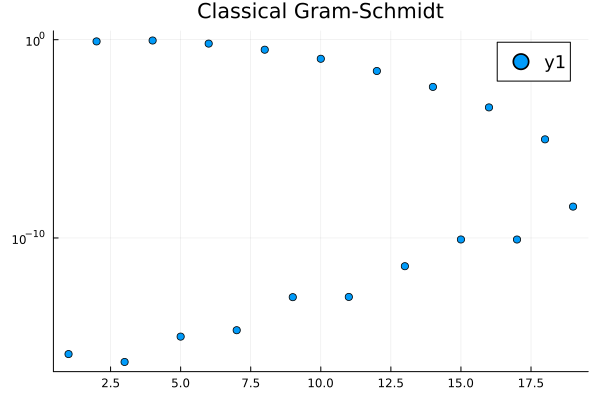

In [74]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, _ = gram_schmidt_classical(A)
v = A[:,end]
@show norm(v)
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Classical Gram-Schmidt")

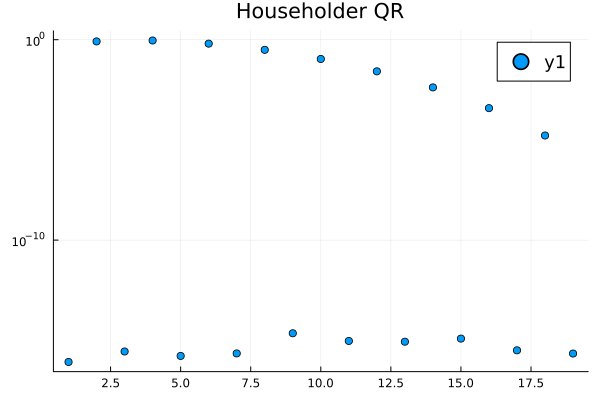

In [75]:
Q = reflectors_to_dense(qr_householder(A)[1])
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Householder QR")

# Composition of reflectors

\begin{align}
(I - 2 v v^T) (I - 2 w w^T) &= I - 2 v v^T - 2 w w^T + 4 v (v^T w) w^T \\
&= I - \Bigg[v \Bigg| w \Bigg] \begin{bmatrix} 2 & -4 v^T w \\ 0 & 2 \end{bmatrix} \begin{bmatrix} v^T \\ w^T \end{bmatrix}
\end{align}

This turns applying reflectors from a sequence of vector operations to a sequence of (smallish) matrix operations. It's the key to high performance and the native format (`QRCompactWY`) returned by Julia `qr()`.

In [76]:
Q, R = qr(A)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}
Q factor: 20×20 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}
R factor:
20×20 Matrix{Float64}:
 -4.47214  0.0      -1.64763       0.0          …  -0.514468      2.22045e-16
  0.0      2.71448   1.11022e-16   1.79412         -2.498e-16     0.823354
  0.0      0.0      -1.46813       5.55112e-17     -0.944961     -2.23779e-16
  0.0      0.0       0.0          -0.774796         3.83808e-17  -0.913056
  0.0      0.0       0.0           0.0              0.797217     -4.06264e-16
  0.0      0.0       0.0           0.0          …  -3.59496e-16   0.637796
  0.0      0.0       0.0           0.0             -0.455484     -1.3936e-15
  0.0      0.0       0.0           0.0              4.40958e-16  -0.313652
  0.0      0.0       0.0           0.0             -0.183132      1.64685e-15
  0.0      0.0       0.0           0.0              4.82253e-16   0.109523
  0.0      0.0       0.0           0.0          

# This works even for very nonsquare matrices

In [77]:
A = rand(1000000, 5)
Q, R = qr(A)
@show size(Q)
@show norm(Q*R - A)
R

size(Q) = (1000000, 1000000)
norm(Q * R - A) = 3.059842369178539e-12


5×5 Matrix{Float64}:
 -577.004  -433.339  -433.146  -433.187  -433.032
    0.0     381.804   163.137   163.734   163.39
    0.0       0.0     345.012   103.551   103.128
    0.0       0.0       0.0    -329.306   -75.7609
    0.0       0.0       0.0       0.0    -320.388

This is known as a "full" (or "complete") QR factorization, in contrast to a reduced QR factorization in which $Q$ has the same shape as $A$.
* How much memory does $Q$ use?

# Compare to [`numpy.linalg.qr`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html)

* Need to decide up-front whether you want full or reduced QR.
* Full QR is expensive to represent.

# Cholesky QR

$$ R^T R = (QR)^T QR = A^T A$$

so we should be able to use $L L^T = A^T A$ and then $Q = A L^{-T}$.

In [79]:
function qr_chol(A)
    R = cholesky(A' * A).U
    Q = A / R
    Q, R
end

A = rand(10,4)
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 2.2107277380745723e-15
norm(Q * R - A) = 4.3488656054059265e-16


4.3488656054059265e-16

In [82]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 0.1749736012761826
norm(Q * R - A) = 6.520306397146206e-16


# Can we fix this?

Note that the product of two triangular matrices is triangular.

In [19]:
R = triu(rand(5,5))
R * R

5×5 Matrix{Float64}:
 0.97317  0.166549  0.886643   0.790819  1.41736
 0.0      0.62048   0.559597   1.00648   1.62617
 0.0      0.0       0.0145787  0.449376  0.587352
 0.0      0.0       0.0        0.940909  1.08426
 0.0      0.0       0.0        0.0       0.122084

In [87]:
function qr_chol2(A)
    Q, R = qr_chol(A)
    Q, R1 = qr_chol(Q)
    Q, R1 * R
end

x = LinRange(-1, 1, 20)
A = vander(x)
Q, R = qr_chol2(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 1.3276319786294278e-15
norm(Q * R - A) = 1.0894860257129427e-15


# How fast are these methods?

In [92]:
m, n = 5000, 4000
A = randn(m, n)

@time qr(A);

  1.070449 seconds (9 allocations: 154.787 MiB, 0.06% gc time)


In [94]:
A = randn(m, n)
@time qr_chol(A);

  1.201750 seconds (10 allocations: 396.738 MiB, 17.43% gc time)


# Profiling

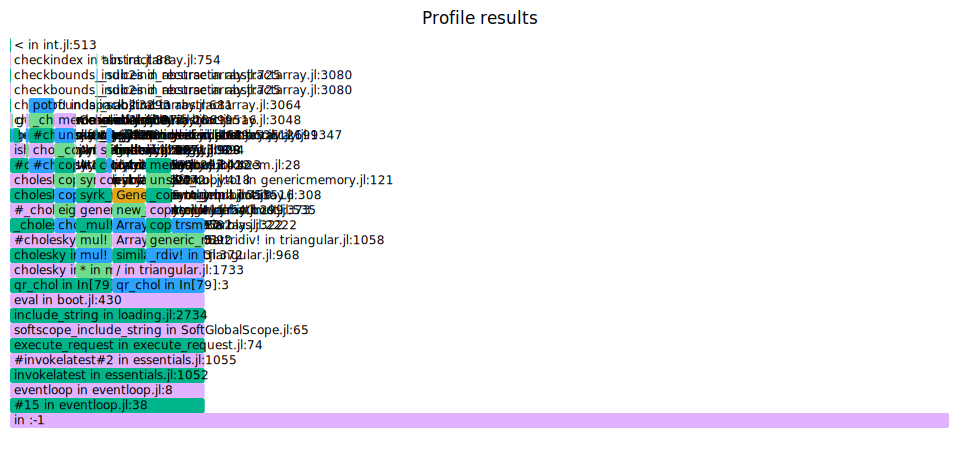

In [95]:
using ProfileSVG

#@profview qr(A)
@profview qr_chol(A)

# Krylov subspaces

Suppose we wish to solve

$$A x = b$$

but only have the ability to apply the action of the $A$ (we do not have access to its entries). A general approach is to work with approximations in a *Krylov subspace*, which has the form

$$ K_n = \big[ b \big| Ab \big| A^2 b \big| \dotsm \big| A^{n-1} b \big] . $$

This matrix is horribly ill-conditioned and cannot stably be computed as written.  Instead, we seek an orthogonal basis $Q_n$ that spans the same space as $K_n$.  We could write this as a factorization

$$ K_n = Q_n R_n $$

where the first column $q_1 = b / \lVert b \rVert$.  The $R_n$ is unnecessary and hopelessly ill-conditioned, so a slightly different procedure is used.

# Arnoldi iteration

The Arnoldi iteration applies orthogonal similarity transformations to reduce $A$ to [Hessenberg form](https://en.wikipedia.org/wiki/Hessenberg_matrix), starting from a vector $q_1 = b/\lVert b \rVert$,

$$ A = Q H Q^* . $$

Let's multiply on the right by $Q$ and examine the first $n$ columns,

$$ A Q_n = Q_{n+1} H_n $$
where $H_n$ is an $(n+1) \times n$ Hessenberg matrix.

# GMRES
$$ A Q_n = Q_{n+1} H_n $$

GMRES (Generalized Minimum Residual) minimizes
$$ \lVert A x - b \rVert $$
over the subspace $Q_n$.  I.e., $x = Q_n y$ for some $y$.  By the Arnoldi recurrence, this is equivalent to
$$ \lVert Q_{n+1} H_n y - b \lVert $$
which can be solved by minimizing
$$ \lVert H_n y - Q_{n+1}^* b \rVert . $$
Since $q_1 = b/\lVert b \lVert$, the least squares problem is to minimize
$$ \Big\lVert H_n y - \lVert b \rVert e_1 \Big\rVert . $$
The solution of this least squares problem is achieved by incrementally updating a $QR$ factorization of $H_n$.

## Notes
* The solution $x_n$ constructed by GMRES at iteration $n$ is not explicitly available.  If a solution is needed, it must be constructed by solving the $(n+1)\times n$ least squares problem and forming the solution as a linear combination of the $n$ vectors $Q_n$.  The leading cost is $2mn$ where $m \gg n$.
* The residual vector $r_n = A x_n - b$ is not explicitly available in GMRES.  To compute it, first build the solution $x_n = Q_n y_n$.
* GMRES minimizes the 2-norm of the residual $\lVert r_n \rVert$ which is equivalent to the $A^* A$ norm of the error $\lVert x_n - x_* \rVert_{A^* A}$.

# More notes on GMRES

* GMRES needs to store the full $Q_n$, which is unaffordable for large $n$ (many iterations).  The standard solution is to choose a "restart" $k$ and to discard $Q_n$ and start over with an initial guess $x_k$ after each $k$ iterations.  This algorithm is called GMRES(k).  PETSc's default solver is GMRES(30) and the restart can be controlled using the run-time option `-ksp_gmres_restart`.
* Most implementations of GMRES use classical Gram-Schmidt because it is much faster in parallel (one reduction per iteration instead of $n$ reductions per iteration).  The PETSc option `-ksp_gmres_modifiedgramschmidt` can be used when you suspect that classical Gram-Schmidt may be causing instability.
* There is a very similar (and older) algorithm called GCR that maintains $x_n$ and $r_n$.  This is useful, for example, if a convergence tolerance needs to inspect individual entries.  GCR requires $2n$ vectors instead of $n$ vectors, and can tolerate a nonlinear preconditioner.  FGMRES is a newer algorithm with similar properties to GCR.